In [ ]:
from neurovelo.train import Trainer
from neurovelo.utils import ModelAnalyzer,latent_data,evaluate,decode_gene_velocity,vector_fields_similarity
from neurovelo.grn import GraphMaker
import networkx as nx
from matplotlib.lines import Line2D
import scvelo as scv
import scanpy as sc
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import anndata
import csv
import pandas as pd

import torch as th


In [2]:
print("hello")

hello


In [79]:
import os
os.getcwd()
os.chdir('/Users/clara.canavese/Documents/PhD/Simulators')

In [80]:
# adata = anndata.read_h5ad("./dyngen/dataset_gtvel.h5ad")
adata = anndata.read_h5ad("./dyngen/dataset_grn.h5ad")
# adata_latentvelo = anndata.read_h5ad("./dyngen/latent_velo/bifurcation.h5ad")
# adata_cr = anndata.read_h5ad("./dyngen/bifurcating.h5ad")

In [36]:
adata

AnnData object with n_obs × n_vars = 1000 × 121
    obs: 'step_ix', 'simulation_i', 'sim_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    uns: 'regulatory_network', 'regulatory_network_regulators', 'regulatory_network_targets', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions'
    obsm: 'dimred', 'regulatory_network_sc'
    layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts', 'rna_velocity'

In [200]:

adata_nb.obs['time'] = adata_nb.uns['traj_progressions']['percentage']
adata_nb.obs['global_time'] = adata_nb.obs['sim_time']
del adata_nb.obs['sim_time']

# adata.uns['endpoints'] = adata_cr.uns['endpoints']
adata_nb.uns['gt_velocity'] = adata_nb.layers['rna_velocity']
# adata.uns['startpoints'] = adata_cr.uns['startpoints']

In [81]:
adata.obs['cell_id'] = adata.obs.index
adata.obs.index = [i for i in range(adata.shape[0])]
adata.obs['from'] = adata.uns['traj_progressions']['from']
adata.obs['to'] = adata.uns['traj_progressions']['to']
lineage = []
for i in range(adata.shape[0]):
    lineage.append(adata.obs['from'].iloc[i] + ' -> ' + adata.obs['to'].iloc[i])
    

In [82]:
adata.uns['gt_velocity'] = adata.layers['rna_velocity']
del adata.layers['rna_velocity']

In [83]:
adata.obs['lineage'] = lineage
adata.obs

,step_ix,simulation_i,sim_time,cell_id,from,to,lineage
0,13891,57,684.008333,cell1,sC,sEndC,sC -> sEndC
1,4996,21,240.008333,cell2,sB,sC,sB -> sC
2,21331,88,188.008333,cell3,sB,sC,sB -> sC
3,18148,75,144.000000,cell4,sB,sC,sB -> sC
4,2097,9,356.008333,cell5,sC,sEndC,sC -> sEndC
...,...,...,...,...,...,...,...
995,16735,69,348.008333,cell996,sC,sEndC,sC -> sEndC
996,10570,44,88.000000,cell997,sA,sB,sA -> sB
997,18127,75,60.008333,cell998,sA,sB,sA -> sB
998,20335,84,108.000000,cell999,sA,sB,sA -> sB


In [84]:
adata.layers['spliced'] = adata.layers['counts_spliced']
adata.layers['unspliced'] = adata.layers['counts_unspliced']
del adata.layers['counts_spliced']
del adata.layers['counts_unspliced']

In [85]:
adata.obs_names = adata.obs_names.astype(str)

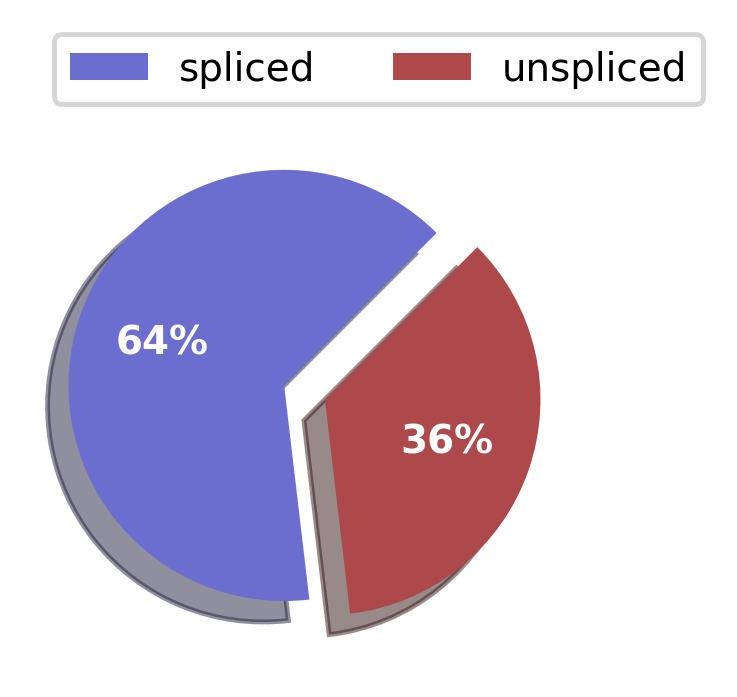

In [86]:
scv.pl.proportions(adata, layers=['spliced','unspliced'], dpi=350)

In [87]:
del adata.layers['counts_protein']
del adata.layers['logcounts']

In [88]:
adata

AnnData object with n_obs × n_vars = 1000 × 121
    obs: 'step_ix', 'simulation_i', 'sim_time', 'cell_id', 'from', 'to', 'lineage'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    uns: 'regulatory_network', 'regulatory_network_regulators', 'regulatory_network_targets', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'gt_velocity'
    obsm: 'dimred', 'regulatory_network_sc'
    layers: 'spliced', 'unspliced'

         Falling back to preprocessing with `sc.pp.pca` and default params.


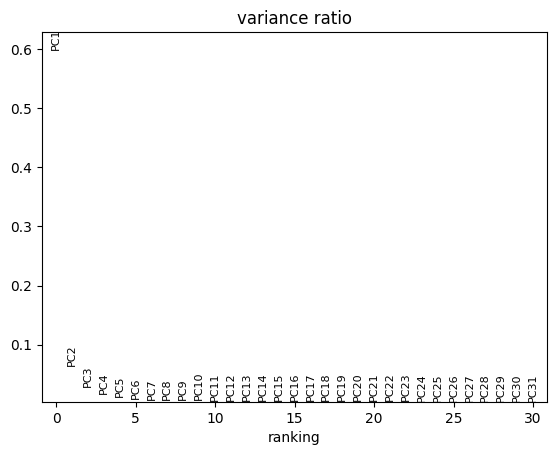

In [89]:
sc.pp.neighbors(adata, n_pcs=30 , n_neighbors=30)
sc.tl.pca(adata, random_state=0)
sc.pl.pca_variance_ratio(adata)

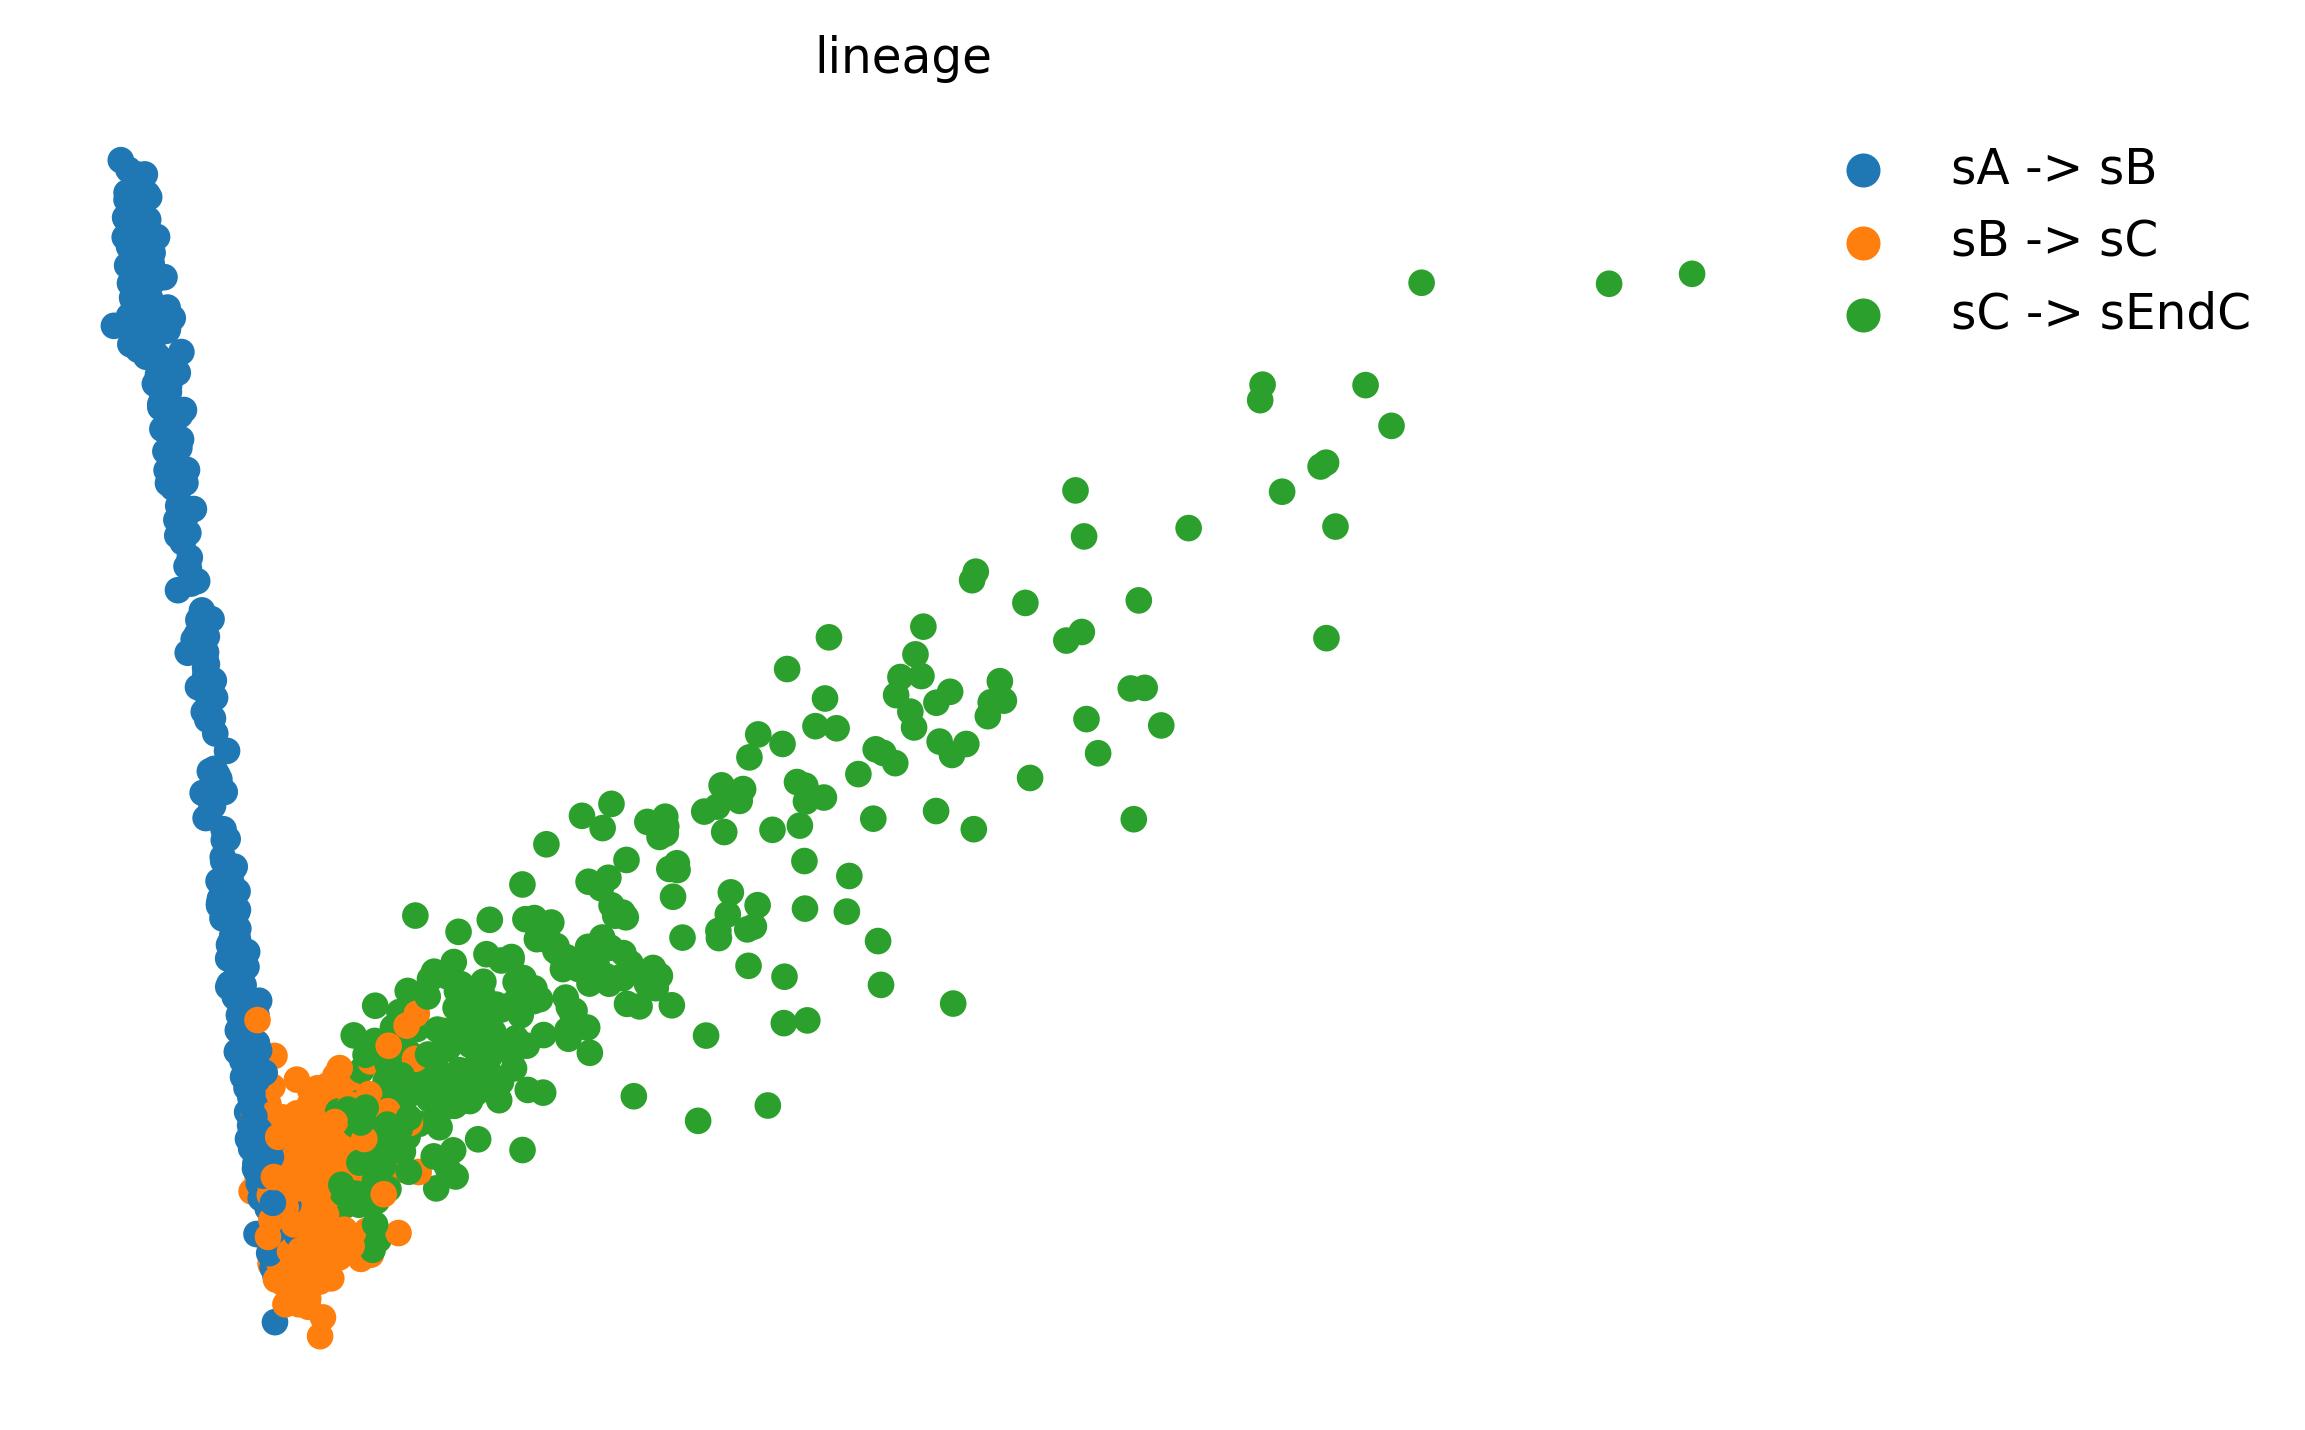

In [90]:
# Visualize the PCA and UMAP
scv.pl.scatter(adata, basis='pca', color='lineage', dpi=350)

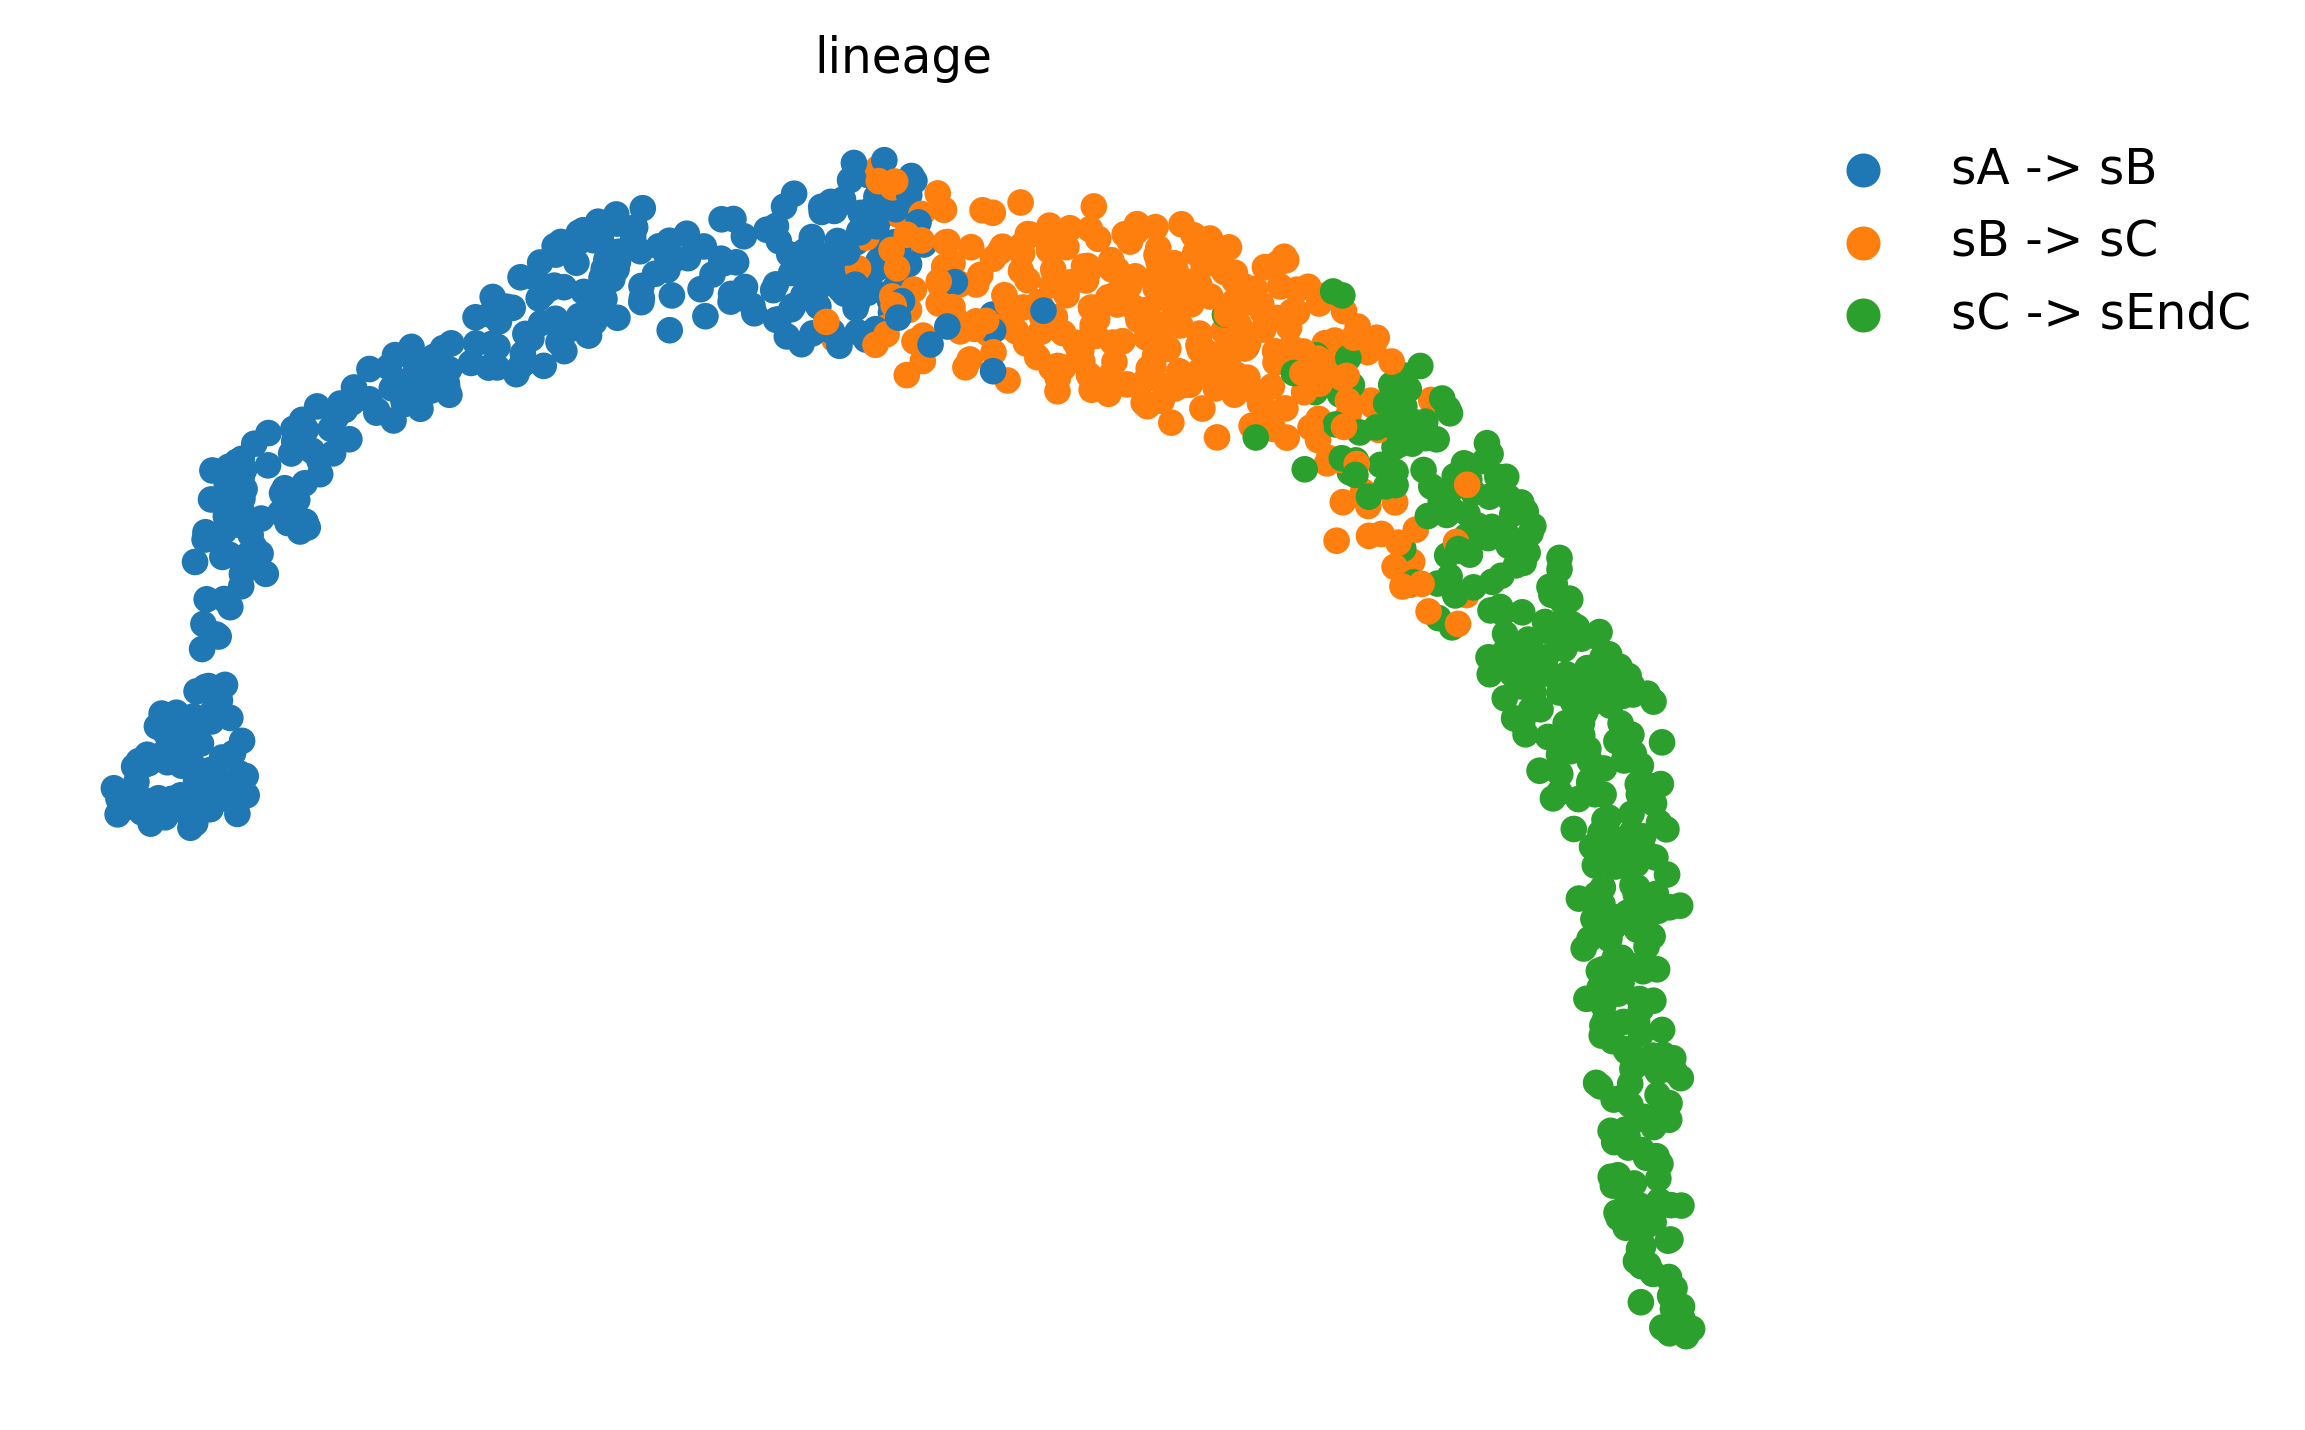

In [91]:
# Visualize the PCA and UMAP
sc.tl.umap(adata, random_state=0)
scv.pl.scatter(adata, basis='umap', color='lineage', dpi=350)

In [93]:
# Compute velocities with scVelo
scv.pp.moments(adata)

Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [69]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')

recovering dynamics (using 1/8 cores)


  0%|          | 0/121 [00:00<?, ?gene/s]

    finished (0:00:25) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


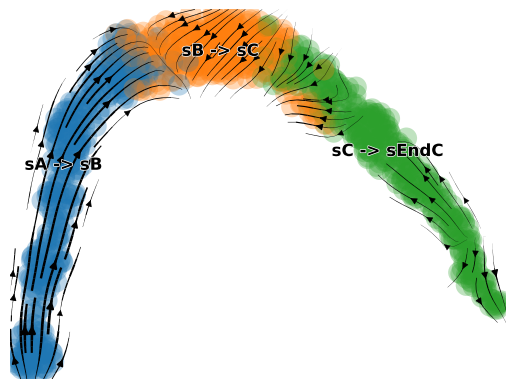

In [70]:
# Project velocities onto the embedding
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, legend_fontsize=12, title='', smooth=0.8, min_mass=2.5, 
                                color='lineage')

## Neurovelo

In [49]:
from neurovelo.train import Trainer

In [50]:
import os
os.getcwd()

'/Users/clara.canavese/Documents/PhD/Simulators'

In [71]:
adata

AnnData object with n_obs × n_vars = 1000 × 121
    obs: 'step_ix', 'simulation_i', 'sim_time', 'cell_id', 'from', 'to', 'lineage', 'sample', 'latent_time', 'n_counts', 'spliced_velocity_self_transition', 'velocity_self_transition'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'spliced_velocity_gamma', 'spliced_velocity_qreg_ratio', 'spliced_velocity_r2', 'spliced_velocity_genes', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'regulatory_network', 'regulatory_network_regulators', 'regulatory_network_targets', 'traj_dimred_segmen

In [94]:
adata.obs['sample'] = 0

model = Trainer(adata,layer='Ms', odesample_obs = 'sample', n_sample=1, percent=0.8, nepoch=300
                ,reconstruct_xt=False, batch_size=100, n_latent=20, n_ode_hidden=50, n_vae_hidden=50, random_state=1)
model.train()

model.save_model('./dyngen/neurovelo','linear_vel_grn')

Using spliced and unspliced moments


Epoch 300: 100%|██████████| 300/300 [01:22<00:00,  3.63epoch/s, train_loss=0.204, val_loss=0.195]


In [95]:
latent_adata = latent_data(adata,'./dyngen/neurovelo/linear_vel_grn.pth', layer='Ms')
scv.pp.neighbors(latent_adata, n_neighbors=30)
latent_adata.obsm['X_umap'] = adata.obsm['X_umap']

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


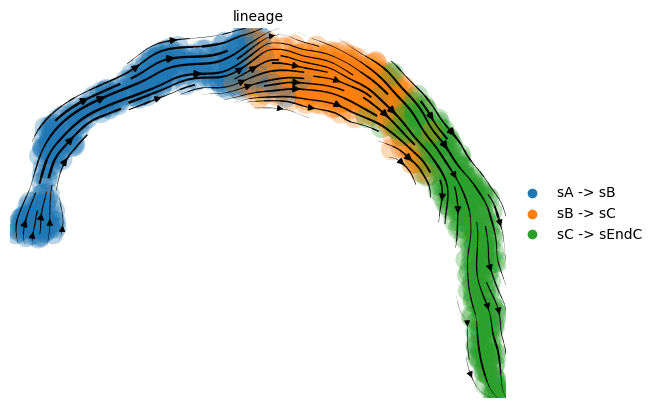

In [96]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity', xkey='Ms')
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='umap')
scv.pl.velocity_embedding_stream(latent_adata,basis='umap',vkey='spliced_velocity', color='lineage',legend_loc='far right')

In [97]:
adata.layers['spliced_velocity'] = decode_gene_velocity(adata,'./dyngen/neurovelo/linear_vel_grn.pth', layer='spliced')

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


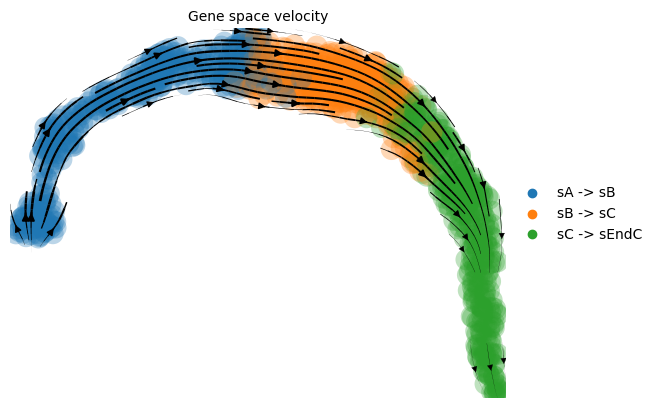

In [98]:
scv.tl.velocity_graph(adata, vkey='spliced_velocity', xkey='Ms')
scv.tl.velocity_embedding(adata, vkey='spliced_velocity', basis='umap')
scv.pl.velocity_embedding_stream(adata,basis='umap',vkey='spliced_velocity', color='lineage',legend_loc='far right', title="Gene space velocity")

### Evaluation

In [106]:
cluster_edges = [
    ("sA -> sB", "sB -> sC"), 
    ("sB -> sC", "sC -> sCend")]

evaluate(latent_adata, cluster_edges, 'lineage','spliced_velocity')

# Cross-Boundary Direction Correctness (A->B)
{('sA -> sB', 'sB -> sC'): 0.1306450627167135}
Total Mean: 0.1306450627167135
# In-cluster Coherence
{'sA -> sB': 0.9998922425479372, 'sB -> sC': 0.9999583837838183, 'sC -> sEndC': 0.9999821928951014}
Total Mean: 0.9999442730756188


{'Cross-Boundary Direction Correctness (A->B)': ({('sA -> sB',
    'sB -> sC'): 0.1306450627167135},
  0.1306450627167135),
 'In-cluster Coherence': ({'sA -> sB': 0.9998922425479372,
   'sB -> sC': 0.9999583837838183,
   'sC -> sEndC': 0.9999821928951014},
  0.9999442730756188)}

#### Multiple models

In [100]:
for i in range(6):
    model = Trainer(adata,layer='Ms', odesample_obs = 'sample', n_sample=1, percent=0.8, nepoch=200
                ,reconstruct_xt=False, batch_size=100, n_latent=20, n_ode_hidden=50, n_vae_hidden=50, random_state = i)
    model.train()
    model.save_model('./dyngen/neurovelo/multiple_models',f'Ms_linear_{i}_z')

Using spliced and unspliced moments


Epoch 200: 100%|██████████| 200/200 [00:54<00:00,  3.69epoch/s, train_loss=0.243, val_loss=0.236]


Using spliced and unspliced moments


Epoch 200: 100%|██████████| 200/200 [00:52<00:00,  3.83epoch/s, train_loss=0.259, val_loss=0.245]


Using spliced and unspliced moments


Epoch 200: 100%|██████████| 200/200 [00:51<00:00,  3.90epoch/s, train_loss=0.253, val_loss=0.26] 


Using spliced and unspliced moments


Epoch 200: 100%|██████████| 200/200 [00:51<00:00,  3.89epoch/s, train_loss=0.254, val_loss=0.253]


Using spliced and unspliced moments


Epoch 200: 100%|██████████| 200/200 [00:56<00:00,  3.53epoch/s, train_loss=0.267, val_loss=0.27] 


Using spliced and unspliced moments


Epoch 200: 100%|██████████| 200/200 [00:58<00:00,  3.40epoch/s, train_loss=0.277, val_loss=0.265]


([<matplotlib.axis.XTick at 0x173d4c6a0>], [Text(0, 0, 'zspliced')])

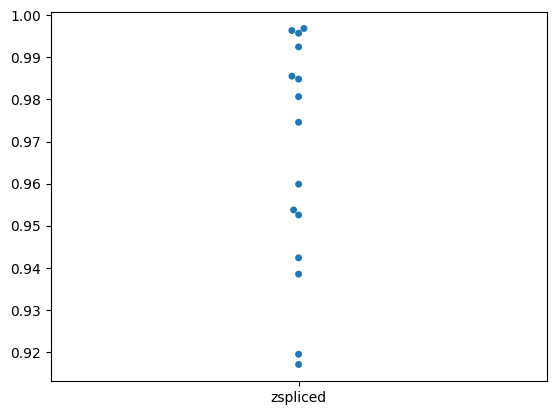

In [101]:
zspliced_models = glob.glob('./dyngen/neurovelo/multiple_models/*')

zspliced_cos_sim, zspliced_mean = vector_fields_similarity(adata, zspliced_models, layer="Ms")

sns.swarmplot([list(zspliced_cos_sim.values())])
plt.xticks([0],['zspliced'])

### GRN

In [110]:
adata.obs['treatment'] = 'no_treatment'

analyzer = ModelAnalyzer(data=adata, n_vectors=10, layer='Ms', models_path=zspliced_models)
results = analyzer.models_output()
gene_ranking_order, gene_ranking_mean = analyzer.gene_ranking()

#List of important genes for the dynamics
for g in gene_ranking_order['no_treatment'][0][:20].values:
    print(g)

Target12
Target45
Target46
Target2
Target44
Target8
Target98
Target99
Target11
Target51
Target21
Target20
Target4
Target1
Target100
Target13
Target43
Target14
Target27
Target41


In [119]:
adata.obs['clusters'] = adata.obs['lineage']
del adata.obs['lineage']   

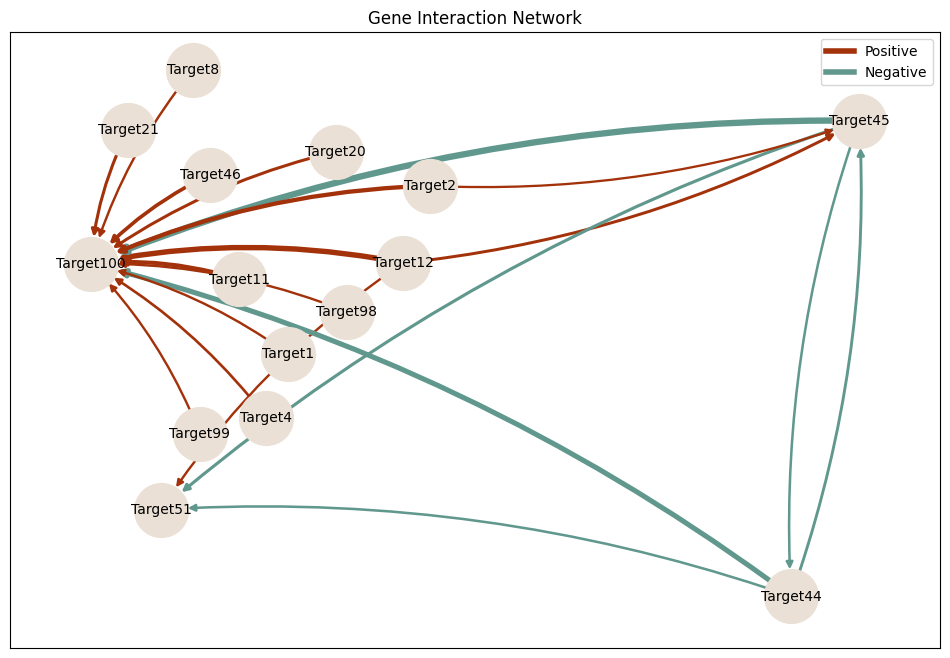

In [122]:
graph_maker = GraphMaker(adata, np.random.choice(zspliced_models), layer='Ms')

genes_of_interest = gene_ranking_order['no_treatment'][0][:15].values  # List of ALL genes
n_frames = 1  # Number of frames for the analysis 
take_windows = False  # Whether to take windows  (for animated network)
ci = 0  # Start index for cell of ptime
take_smallest_ptime = False  # Whether to take smallest ptime cells

# Call the graph_maker method
A, gi, g, mean_ptime, sorted_cell_value, cell_of_ptime = graph_maker.graph_maker(
    genes_of_interest, reverse=True, n_frames=n_frames, take_windows=take_windows
)

# Plot the graph
threshold_a = 0.08 # Threshold for significant connections
G_nv = graph_maker.create_graph(A, gi, g, threshold_a)
pos_nv = nx.spring_layout(G_nv)

graph_maker.plot_custom_graph(G_nv,edge_width=20)

In [133]:
reg_net_filtered = reg_net[reg_net['target'].isin(genes_of_interest)]
reg_net_filtered['weight'] = reg_net_filtered['strength']*reg_net_filtered['effect']

,regulator,target,strength,effect
24,A3_TF1,Target1,97.413698,1
25,A3_TF1,Target2,50.257371,1
27,A3_TF1,Target4,6.647465,1
31,A3_TF1,Target8,11.346285,1
34,A3_TF1,Target11,5.591119,1
35,A3_TF1,Target12,48.036279,1
43,A4_TF1,Target20,54.082539,1
44,A4_TF1,Target21,40.899566,1
68,A2_TF1,Target44,36.880778,-1
69,A2_TF1,Target45,74.284526,-1


In [134]:
reg_net_filtered['weight'] = reg_net_filtered['strength']*reg_net_filtered['effect']

In [135]:
reg_net_filtered

,regulator,target,strength,effect,weight
24,A3_TF1,Target1,97.413698,1,97.413698
25,A3_TF1,Target2,50.257371,1,50.257371
27,A3_TF1,Target4,6.647465,1,6.647465
31,A3_TF1,Target8,11.346285,1,11.346285
34,A3_TF1,Target11,5.591119,1,5.591119
35,A3_TF1,Target12,48.036279,1,48.036279
43,A4_TF1,Target20,54.082539,1,54.082539
44,A4_TF1,Target21,40.899566,1,40.899566
68,A2_TF1,Target44,36.880778,-1,-36.880778
69,A2_TF1,Target45,74.284526,-1,-74.284526


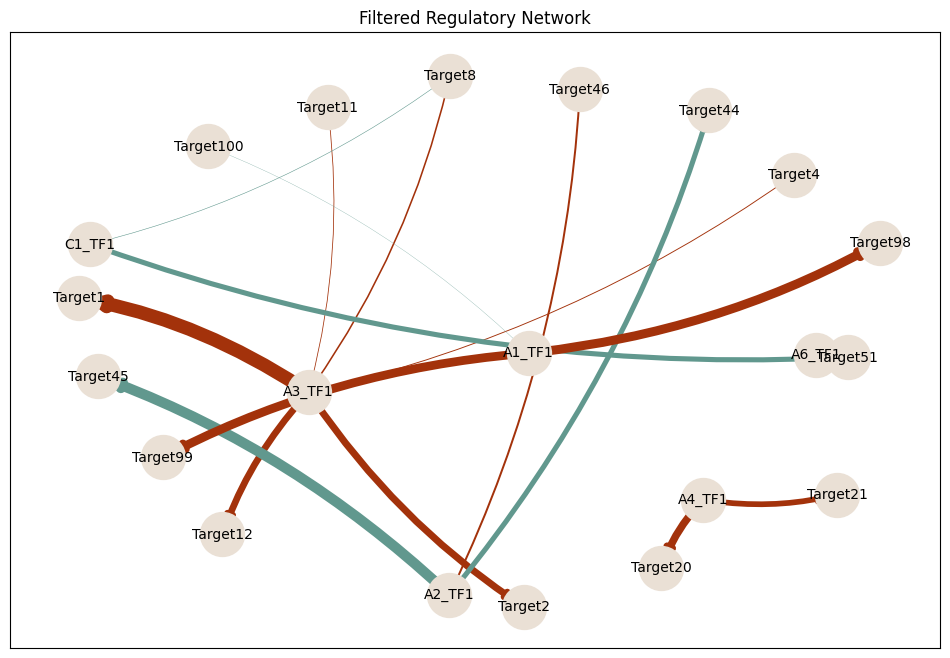

In [142]:
# Create a directed graph from the filtered regulatory network
G_filtered = nx.from_pandas_edgelist(reg_net_filtered, source='regulator', target='target', edge_attr='weight', create_using=nx.DiGraph())

# Define the layout for the graph
pos_filtered = nx.spring_layout(G_filtered)

# Draw the nodes and edges
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_filtered, pos_filtered, node_color='#EAE0D5', node_size=1000)
nx.draw_networkx_labels(G_filtered, pos_filtered, font_family='DejaVu Sans', font_size=10, font_color='black')
for u, v, data in G_filtered.edges(data=True):
    color = '#A3320B' if data['weight'] > 0 else '#61988E'
    width = abs(data['weight'])/10
    nx.draw_networkx_edges(G_filtered, pos_filtered, edgelist=[(u, v)], width=width, edge_color=color, arrows=True, arrowsize=10, connectionstyle=f"arc3,rad={0.10}", node_size=150)

# Create custom legend
legend_elements = [
    Line2D([0], [0], color='#A3320B', lw=4, label='Positive'),
    Line2D([0], [0], color='#61988E', lw=4, label='Negative')
]


plt.title("Filtered Regulatory Network")
plt.show()

## CellRank notebook

In [144]:
adata_cr.var_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '240', '241', '242', '243', '244', '245', '246', '247', '248', '249'],
      dtype='object', length=250)

In [163]:
adata_cr.obs_names

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '991', '992', '993', '994', '995', '996', '997', '998', '999', '1000'],
      dtype='object', length=1000)

In [166]:
adata.obs_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '990', '991', '992', '993', '994', '995', '996', '997', '998', '999'],
      dtype='object', length=1000)

In [165]:
adata.obs_names = adata.obs_names.astype(str)

In [34]:
# Simulated dataset from dyngen paper
adata_cr = anndata.read_h5ad("./dyngen/bifurcating.h5ad")

In [35]:
# create raw object
adata_raw = adata_cr.copy()
sc.pp.filter_genes(adata_raw, min_cells=3)
scv.pp.normalize_per_cell(adata_raw)
sc.pp.log1p(adata_raw)

# annotate highly variable genes
sc.pp.highly_variable_genes(adata_raw)
adata_cr.raw = adata_raw

Normalized count data: X, spliced, unspliced.


In [36]:
# preprocessing for the actual adata object
scv.pp.filter_genes(adata_cr, min_shared_counts=20)
scv.pp.normalize_per_cell(adata_cr)
scv.pp.filter_genes_dispersion(adata_cr, n_top_genes=34)
scv.pp.log1p(adata_cr)

Filtered out 42 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 34 highly variable genes.


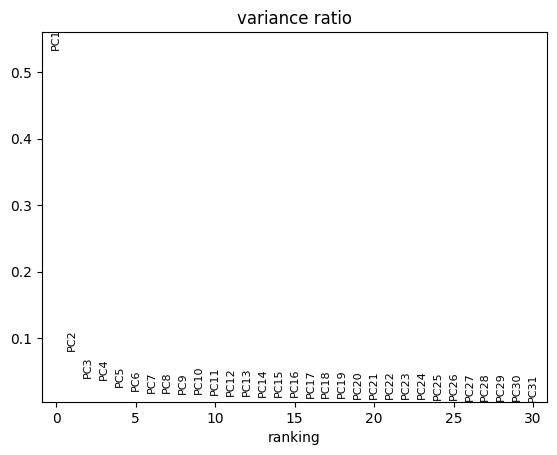

In [12]:
# perform PCA
sc.tl.pca(adata_cr, random_state=0)
sc.pl.pca_variance_ratio(adata_cr)
sc.pp.neighbors(adata_cr, n_pcs=7, n_neighbors=15, random_state=0)

/Users/clara.canavese/miniforge3/envs/RNAvel/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


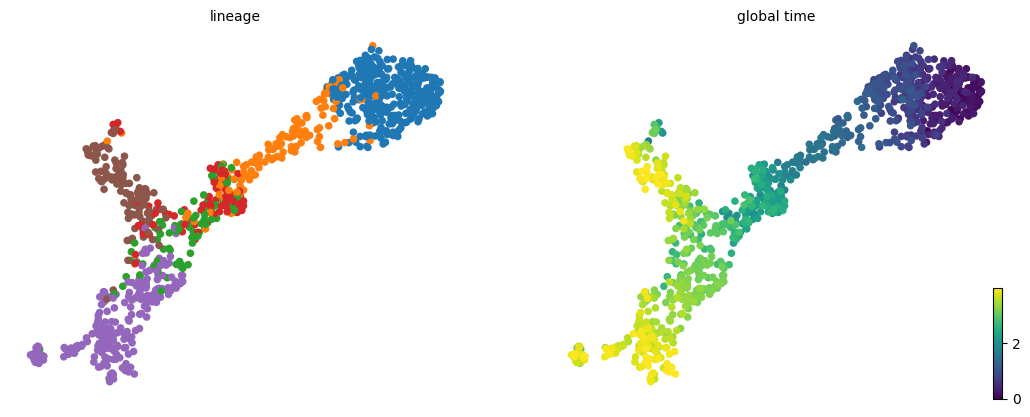

In [13]:
# Visualize UMAP
scv.pl.scatter(adata_cr, color=['lineage','global_time'])

In [15]:
# Compute velocities with scVelo
scv.pp.moments(adata_cr, n_pcs=7)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [16]:
# adapt the same knn graph for the raw object and compute moments
adata_raw.obsp['connectivities'] = adata_cr.obsp['connectivities'].copy()
adata_raw.obsp['distances'] = adata_cr.obsp['distances'].copy()
adata_raw.uns['neighbors'] = adata_cr.uns['neighbors'].copy()

scv.pp.moments(adata_raw, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [17]:
scv.tl.recover_dynamics(adata_cr)
scv.tl.velocity(adata_cr, mode='dynamical')

recovering dynamics (using 1/8 cores)


  0%|          | 0/31 [00:00<?, ?gene/s]

    finished (0:00:05) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


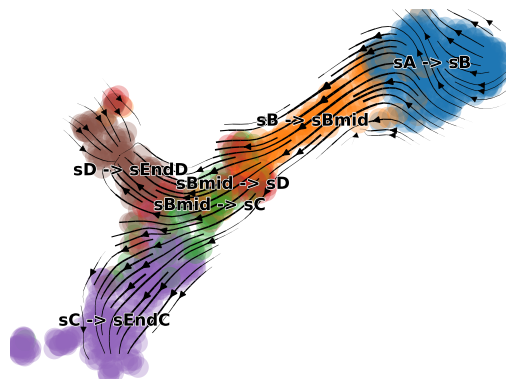

In [18]:
# Project velocities onto the embedding
scv.tl.velocity_graph(adata_cr)
scv.pl.velocity_embedding_stream(adata_cr, legend_fontsize=12, title='', smooth=0.8, min_mass=2.5, 
                                color='lineage')

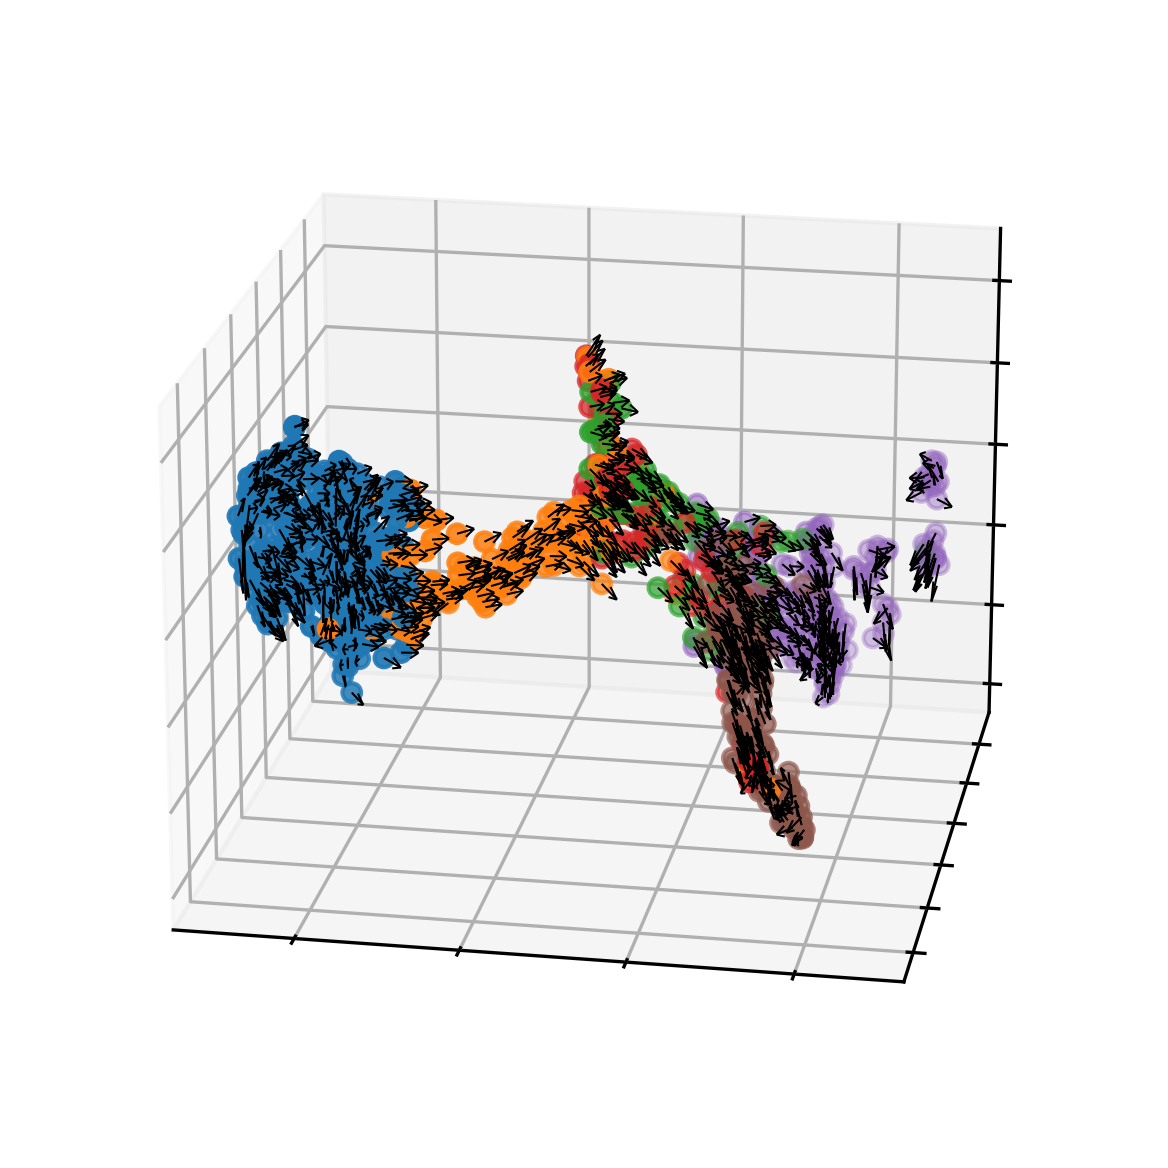

In [19]:
# Show velocities in 3D
umap = adata_cr.obsm['X_umap']
velocity = adata_cr.obsm['velocity_umap']
color = scv.utils.interpret_colorkey(adata_cr, c="lineage")

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap[:, 0], umap[:, 1], umap[:, 2], c=color, cmap='viridis')

# Plot the velocity projection
ax.quiver(umap[:, 0], umap[:, 1], umap[:, 2], velocity[:, 0], velocity[:, 1], velocity[:, 2], color='k',
          normalize=True, length=0.5, arrow_length_ratio=0.5, linewidth = 0.5)

ax.view_init(20, 100)

# turn off the axis ticks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

## csv files

In [61]:
import umap
from sklearn.cluster import KMeans

In [56]:
spliced = pd.read_csv('./dyngen/bifurcation_spliced.csv', index_col=0) 
unspliced = pd.read_csv('./dyngen/bifurcation_unspliced.csv', index_col=0)

adata = scv.AnnData(X = spliced)
adata.layers['unspliced'] = unspliced
adata.layers['spliced'] = spliced

In [74]:
adata.layers['spliced'].shape

(2500, 101)

In [58]:
TFs = spliced.columns[np.where(spliced.columns.str.contains("TF"))[0]]
TFs


Index(['A1_TF1', 'A2_TF1', 'A3_TF1', 'A4_TF1', 'A5_TF1', 'A6_TF1', 'B1_TF1',
       'B2_TF1', 'B3_TF1', 'B4_TF1', 'B5_TF1', 'B6_TF1', 'B7_TF1', 'B8_TF1',
       'B9_TF1', 'B10_TF1', 'B11_TF1', 'B12_TF1', 'B13_TF1', 'B14_TF1',
       'C1_TF1', 'C2_TF1', 'C3_TF1', 'C4_TF1', 'C5_TF1', 'D1_TF1', 'D2_TF1',
       'D3_TF1', 'D4_TF1', 'D5_TF1', 'D6_TF1'],
      dtype='object')

In [60]:
Embedding_Model = umap.UMAP(n_neighbors=30, min_dist=0.5, metric='correlation', n_components=2).fit(spliced[TFs])
Embedding = Embedding_Model.embedding_
#
Embedding_Model = umap.UMAP(n_neighbors=30, min_dist=0.5, metric='correlation', n_components=2).fit(spliced)
All_Genes_Embedding = Embedding_Model.embedding_

In [62]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(Embedding)
Labels = kmeans.labels_
Unique_Labels = np.unique(Labels)

In [78]:
adata.obs['cluster'] = Labels

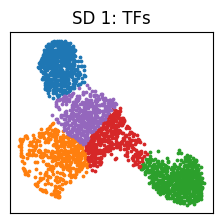

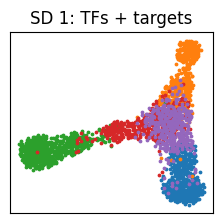

In [65]:
plt.figure(figsize=(2.33,2.33))
plt.title("SD 1: TFs", fontsize=12)
for i in np.arange(Unique_Labels.shape[0]):
    IDs = np.where(Labels == Unique_Labels[i])
    plt.scatter(Embedding[IDs,0],Embedding[IDs,1],s=3)
plt.xticks([])
plt.yticks([])
#plt.subplots_adjust(0.02,0.02,0.98,0.9)
plt.tight_layout()


plt.figure(figsize=(2.33,2.33))
plt.title("SD 1: TFs + targets", fontsize=12)
for i in np.arange(Unique_Labels.shape[0]):
    IDs = np.where(Labels == Unique_Labels[i])
    plt.scatter(All_Genes_Embedding[IDs,0],All_Genes_Embedding[IDs,1],s=3)
plt.xticks([])
plt.yticks([])
#plt.subplots_adjust(0.02,0.02,0.98,0.9)
plt.tight_layout()


plt.show()

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


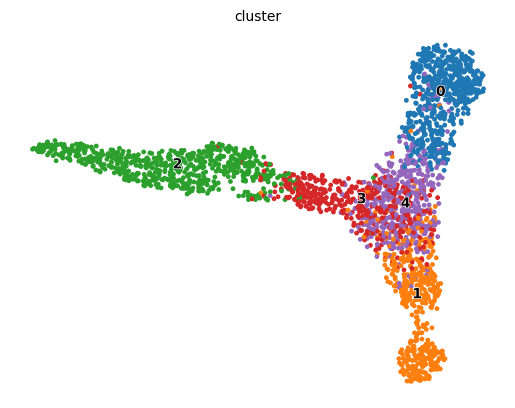

In [80]:
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.tl.umap(adata, min_dist=.5)
scv.pl.umap(adata, color='cluster')

In [81]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [82]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/8 cores)


  0%|          | 0/97 [00:00<?, ?gene/s]

    finished (0:00:48) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [84]:
adata

AnnData object with n_obs × n_vars = 2500 × 101
    obs: 'cluster', 'n_counts', 'velocity_self_transition'
    var: 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'pca', 'neighbors', 'umap', 'cluster_colors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'unspliced', 'spliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [85]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/2500 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


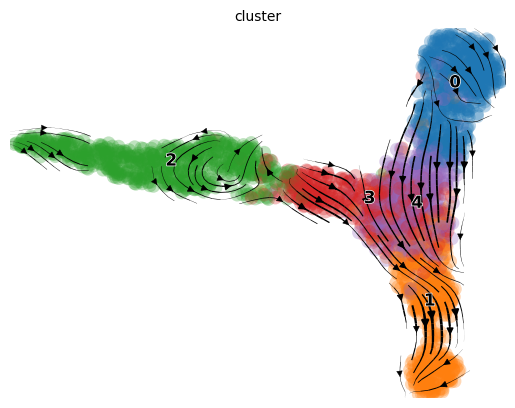

In [86]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color='cluster', legend_loc='on data', legend_fontsize=12)